In [1]:
!pip install -q catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 5.5 MB/s eta 0:00:00


In [2]:
!gdown "https://docs.google.com/uc?export=download&id=1Kjy6nA9sj9sSN6HoZl23p2JjB6pa86VM"
!gdown "https://docs.google.com/uc?export=download&id=1iI0Nia86HTiQ4Xg4GOvHK3My7JwfQ5cD"

Downloading...
From: https://docs.google.com/uc?export=download&id=1Kjy6nA9sj9sSN6HoZl23p2JjB6pa86VM
To: /content/test.pkl
100% 39.7M/39.7M [00:00<00:00, 48.8MB/s]
Downloading...
From: https://docs.google.com/uc?export=download&id=1iI0Nia86HTiQ4Xg4GOvHK3My7JwfQ5cD
To: /content/train.pkl
100% 165M/165M [00:04<00:00, 34.0MB/s]


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from catboost import CatBoostClassifier, Pool
from sklearn.preprocessing import LabelEncoder
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, SimpleImputer
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score, auc, roc_curve, RocCurveDisplay, confusion_matrix, ConfusionMatrixDisplay

pd.set_option('display.max_columns', None)

# Data exploration

In [4]:
train_df = pd.read_pickle('/content/train.pkl')
test_df = pd.read_pickle('/content/test.pkl')
train_df = train_df.sort_values(by='S_2').reset_index(drop=True)
train_df

,customer_ID,S_2,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,D_42,D_43,D_44,B_4,D_45,B_5,R_2,D_46,D_47,D_48,D_49,B_6,B_7,B_8,D_50,D_51,B_9,R_3,D_52,P_3,B_10,D_53,S_5,B_11,S_6,D_54,R_4,S_7,B_12,S_8,D_55,D_56,B_13,R_5,D_58,S_9,B_14,D_59,D_60,D_61,B_15,S_11,D_62,D_63,D_64,D_65,B_16,B_17,B_18,B_19,D_66,B_20,D_68,S_12,R_6,S_13,B_21,D_69,B_22,D_70,D_71,D_72,S_15,B_23,D_73,P_4,D_74,D_75,D_76,B_24,R_7,D_77,B_25,B_26,D_78,D_79,R_8,R_9,S_16,D_80,R_10,R_11,B_27,D_81,D_82,S_17,R_12,B_28,R_13,D_83,R_14,R_15,D_84,R_16,B_29,B_30,S_18,D_86,D_87,R_17,R_18,D_88,B_31,S_19,R_19,B_32,S_20,R_20,R_21,B_33,D_89,R_22,R_23,D_91,D_92,D_93,D_94,R_24,R_25,D_96,S_22,S_23,S_24,S_25,S_26,D_102,D_103,D_104,D_105,D_106,D_107,B_36,B_37,R_26,R_27,B_38,D_108,D_109,D_110,D_111,B_39,D_112,B_40,S_27,D_113,D_114,D_115,D_116,D_117,D_118,D_119,D_120,D_121,D_122,D_123,D_124,D_125,D_126,D_127,D_128,D_129,B_41,B_42,D_130,D_131,D_132,D_133,R_28,D_134,D_135,D_136,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145,target
0,a9fc180e2d2fe7bb5f748b11fde04b91b8b134dedd6e63...,2018-03-01,0.747559,1.326172,0.049652,0.008774,0.003181,0.145996,0.331299,0.007286,NaN,0.085449,0.007122,0.013969,0.075867,0.009918,0.006523,0.439941,0.089172,0.211304,NaN,0.345947,0.035431,1.004883,0.018738,0.000394,0.027817,0.008217,0.192871,0.704102,0.169434,0.004875,0.020599,0.025574,0.002756,1.003906,0.005650,0.112305,0.021072,0.407959,0.046631,NaN,0.019638,0.004341,0.007381,0.011169,0.018860,0.338135,0.752930,0.001437,0.007404,0.523438,0.120911,CO,U,0.163696,0.090088,1.000977,0.616699,0.009628,NaN,0.061249,4.0,0.194214,0.008736,0.287598,0.000012,0.003880,0.008804,0.005692,0.012566,0.002365,0.305664,0.026108,NaN,0.008400,0.003046,0.067383,NaN,0.002790,0.001098,0.118225,0.038757,0.066467,0.008179,0.003420,0.006882,NaN,0.001369,0.003799,0.007576,0.002392,0.006329,0.007477,NaN,0.007339,1.000977,0.015686,0.006840,0.008995,0.005878,0.003588,0.009117,0.002102,NaN,0.0,0.002525,0.006680,NaN,0.003099,0.001054,NaN,1.0,0.002941,0.006710,0.008438,0.003757,0.002672,0.009491,0.008324,0.005409,0.003580,0.009171,0.009064,0.000236,0.002857,0.008087,0.006245,0.005909,0.003517,0.964844,0.138550,0.954102,0.978516,0.005798,0.006660,0.001328,0.002905,NaN,NaN,0.005520,0.006382,0.044891,NaN,1.008789,2.0,NaN,0.003763,NaN,NaN,NaN,0.004353,0.014572,0.008659,0.209961,1.0,0.090515,0.0,2.0,0.089417,0.059753,0.0,0.146729,0.151123,0.009003,0.054749,0.006584,0.0,0.005833,1.000977,1.004883,0.009697,NaN,0.001507,0.004868,NaN,0.007133,0.001586,NaN,NaN,NaN,NaN,NaN,0.006878,0.001645,0.004253,NaN,0.006668,0.009888,0.005371,0
1,53e0b34f34d9d64951754b1a52501157d850c0eb835796...,2018-03-01,0.231445,0.706055,0.416748,0.031082,0.001788,0.475586,0.004211,0.895996,NaN,0.089966,0.381836,0.926758,0.329834,0.012650,0.003618,0.540039,0.388428,0.808105,NaN,0.010048,0.672363,0.002609,0.061066,0.007835,0.664551,0.105835,0.161011,0.141235,0.013916,0.081238,0.035706,0.365234,0.009659,1.000000,0.000373,0.359131,0.012199,0.003490,0.832520,0.112793,0.005814,0.003994,0.480469,NaN,0.095276,0.446533,0.112244,0.851074,0.000836,0.160400,0.071289,CO,O,0.006752,1.001953,0.890137,0.053101,0.902832,NaN,1.000000,6.0,0.190186,0.001913,0.001479,0.002129,0.008957,0.502441,0.251465,0.008469,0.009857,0.708496,0.683594,NaN,0.004471,0.218628,0.269531,0.011620,0.003571,0.004787,NaN,0.167847,0.009819,0.002102,0.008934,0.007221,NaN,0.006008,0.002998,0.005119,0.001772,0.000367,0.005558,NaN,0.009956,1.005859,0.382812,0.007664,0.005470,0.004429,0.004730,0.001917,0.005421,NaN,1.0,0.005871,0.005356,NaN,0.008461,0.003824,NaN,1.0,0.004463,0.001774,0.003016,0.009827,0.001256,0.000230,0.001576,0.000443,0.004566,0.000481,0.007092,0.007973,0.005516,0.009094,0.004833,0.003460,0.003178,0.974609,1.118164,0.970215,0.878418,0.006420,1.080078,1.009766,1.019531,1.034180,NaN,0.342285,0.006756,0.412842,NaN,1.001953,6.0,NaN,0.004398,NaN,NaN,NaN,0.026276,0.638184,0.000638,0.004940,1.0,0.419434,0.0,3.0,0.415771,0.414062,0.0,0.660156,0.429932,0.001400,0.233887,0.009720,1.0,0.009613,1.002930,1.008789,0.002527,

Дисбаланс по таргетам вроде как не значительный. Если бы было хуже, то можно было бы посмотреть в сторону imblearn.

In [5]:
train_df.target.value_counts()

0    272867
1     95843
Name: target, dtype: int64

Просмотр диаграмм рассеивания и бокс-плотов мне особо ничего не дал, поэтому тут их не будет)

In [6]:
num_cols = []
cat_cols = []
datetime_cols = []
for col, val in train_df.drop(columns=['target']).dtypes.items():
    # print(f"{col} - {val}")
    if str(val).startswith(('float', 'int')):
        num_cols.append(col)
        train_df[col] = train_df[col].astype(float)
        test_df[col] = test_df[col].astype(float)
    elif str(val).startswith(('category')):
        cat_cols.append(col)
    elif str(val).startswith(('datetime')):
        datetime_cols.append(col)

train_df['day'] = train_df[datetime_cols[0]].dt.day
train_df['month'] = train_df[datetime_cols[0]].dt.month
train_df['year'] = train_df[datetime_cols[0]].dt.year

datetime_cols = ['day', 'month', 'year']
feature_cols = datetime_cols + cat_cols + num_cols

train_X, train_y = train_df[feature_cols], train_df.target

print(f"num cols len - {len(num_cols)}")
print(f"datetime cols len - {len(datetime_cols)}")
print(f"cat cols len - {len(cat_cols)}")
print(f"Total {len(feature_cols)} features")

<ipython-input-6-9aa9042e2049>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_df['day'] = train_df[datetime_cols[0]].dt.day
<ipython-input-6-9aa9042e2049>:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_df['month'] = train_df[datetime_cols[0]].dt.month
<ipython-input-6-9aa9042e2049>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-

num cols len - 177
datetime cols len - 3
cat cols len - 11
Total 191 features


Посмотрим, сколько столбцов имеет Nan

In [7]:
nans = train_X.isna().sum()
nans[nans.values > 0].sort_values(ascending = False)

D_87     368212
D_88     368040
D_108    366715
D_110    365757
D_111    365757
          ...  
D_41         31
B_2          31
B_38         31
B_30         31
B_27         31
Length: 108, dtype: int64

In [8]:
train_X[cat_cols].nunique()

D_63     6
D_64     4
D_66     1
D_68     6
B_30     3
B_38     7
D_114    2
D_116    2
D_117    7
D_120    2
D_126    2
dtype: int64

customer_ID - похоже мне это ничего не дает

In [9]:
train_df.customer_ID.nunique()

368710

# Preprocessing

## num features

Посмотрим, сколько числовых столбцов имеют менее 10_000 NaN - их мы заполним средним. Хотя по хорошему, всегда лучше предсказывать признак, чем так делать.

UPD: Долго думал, что:

1) надо бы заполнить средним те столбцы, в которых NaN не так много

2) выкинуть столбцы, в которых NaN больше какого-то порога

3) обучить классификатор\регрессор, чтобы заполнить оставшиеся NaN.

В итоге решил в тупую числовые признаки заполнить средним, чтобы сильно не мучаться)

In [8]:
# nans = train_X[num_cols].isna().sum()
# nans[nans.values > 0].sort_values(ascending = False)

D_87     368212
D_88     368040
D_108    366715
D_111    365757
D_110    365757
          ...  
B_20         31
B_22         31
B_33         31
B_2          31
B_26         31
Length: 100, dtype: int64

In [9]:
# слишком долго работает, надоело ждать
# imp_num = IterativeImputer(estimator=RandomForestRegressor(n_estimators=10, max_depth=10),
#                             initial_strategy='mean',
#                             max_iter=10, random_state=0)

# train_X[num_cols] = imp_num.fit_transform(train_X[num_cols])

# другой вариант - заполнить средними
# imp_num = SimpleImputer(strategy='mean')
# train_X[num_cols] = imp_num.fit_transform(train_X[num_cols])

<ipython-input-9-58f22038e1c5>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_X[num_cols] = imp_num.fit_transform(train_X[num_cols])


In [10]:
# nans = train_X[num_cols].isna().sum()
# nans[nans.values > 0].sort_values(ascending = False)

Series([], dtype: int64)

## cat features

D_66 можно выкинуть, т.к. почти полностью пустой столбец

In [12]:
# nans = train_X[cat_cols].isna().sum().sort_values(ascending = False)
# nans[(nans.values>0)]

D_66     326218
D_68       7199
D_114      4719
D_116      4719
D_117      4719
D_120      4719
B_30         31
B_38         31
dtype: int64

In [10]:
cat_cols.remove('D_66')
feature_cols.remove('D_66')
train_X = train_X[feature_cols]

In [14]:
# тоже долго, даже если менять глубину\кол-во деревьев\итераций\..
# le_encoder = LabelEncoder()

# train_X[cat_cols] = train_X[cat_cols].apply(lambda series: pd.Series(
#     le_encoder.fit_transform(series[series.notnull()]),
#     index=series[series.notnull()].index
# ))

# imp_cat = IterativeImputer(estimator=RandomForestClassifier(n_estimators=10, max_depth=10),
#                             initial_strategy='most_frequent',
#                             max_iter=10, random_state=0)

# train_X[cat_cols] = imp_cat.fit_transform(train_X[cat_cols])

# другой вариант - заполнить категориальные Nan самыми частыми значениями
# imp_cat = SimpleImputer(strategy="most_frequent")
# train_X[cat_cols] = imp_cat.fit_transform(train_X[cat_cols])

In [15]:
# nans = train_X[cat_cols].isna().sum().sort_values(ascending = False)
# nans[(nans.values>0)]

Series([], dtype: int64)

# Train cross-val

Шафлить не будем, учимся на раннем сплите по времени, а валидируемся на следующем

[    0     1     2 ... 61452 61453 61454]
[ 61455  61456  61457 ... 122903 122904 122905]
Fold 0:
precision: 0.8964837273579188
recall: 0.8968283673170494
f1_score: 0.8966476840707889
ROC AUC: 0.8639204598941891


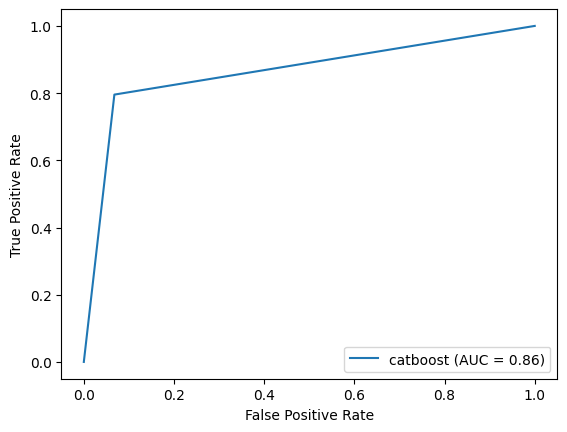

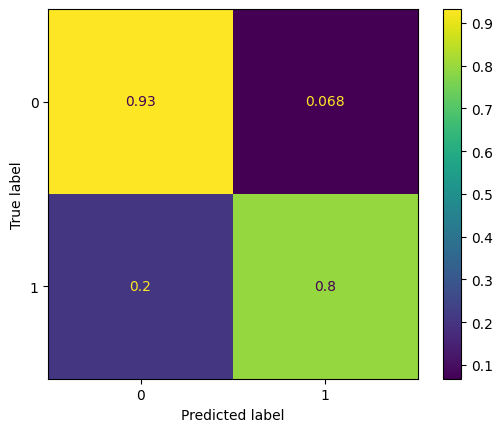

------------
[     0      1      2 ... 122903 122904 122905]
[122906 122907 122908 ... 184354 184355 184356]
Fold 1:
precision: 0.8990949558172264
recall: 0.8994646140827651
f1_score: 0.8992696873813366
ROC AUC: 0.8666250842131041


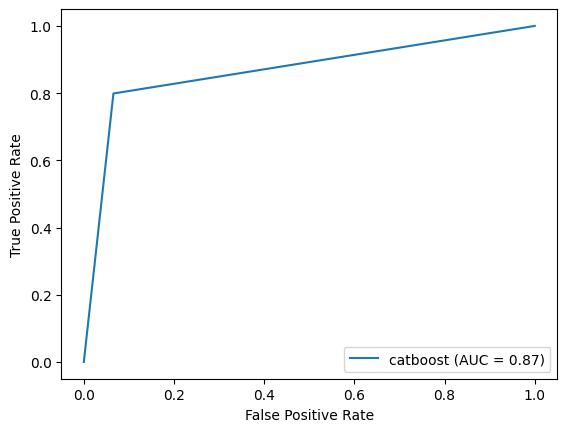

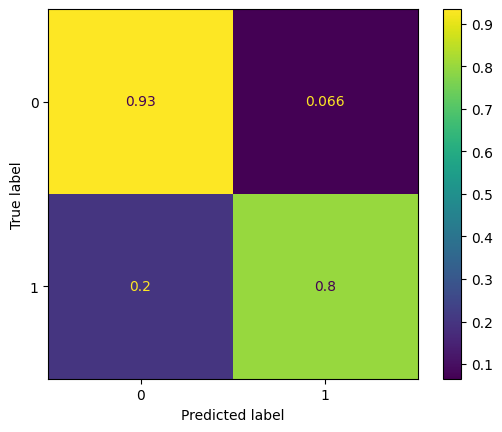

------------
[     0      1      2 ... 184354 184355 184356]
[184357 184358 184359 ... 245805 245806 245807]
Fold 2:
precision: 0.9055771801893372
recall: 0.906185416022522
f1_score: 0.9058477291348559
ROC AUC: 0.8727434637396833


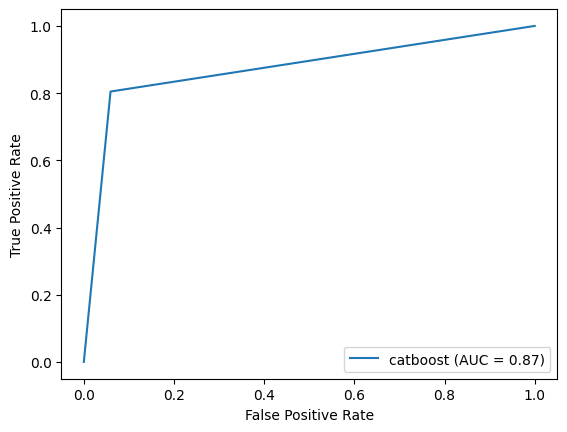

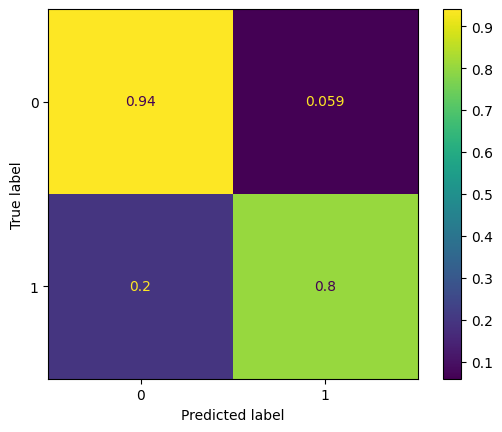

------------
[     0      1      2 ... 245805 245806 245807]
[245808 245809 245810 ... 307256 307257 307258]
Fold 3:
precision: 0.8986241741899025
recall: 0.8988462352117947
f1_score: 0.8987311121153272
ROC AUC: 0.8709071695537028


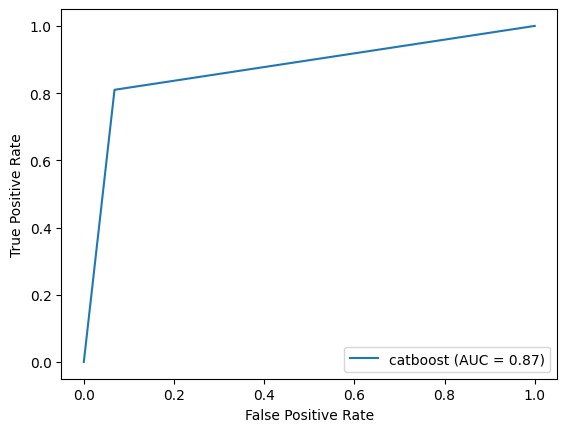

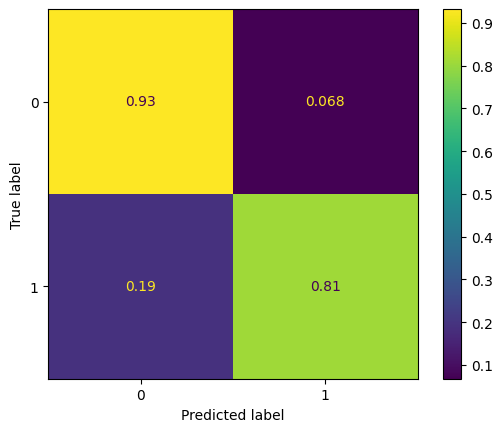

------------
[     0      1      2 ... 307256 307257 307258]
[307259 307260 307261 ... 368707 368708 368709]
Fold 4:
precision: 0.9042832311544572
recall: 0.9045906494605458
f1_score: 0.9044302530970674
ROC AUC: 0.8695018862203292


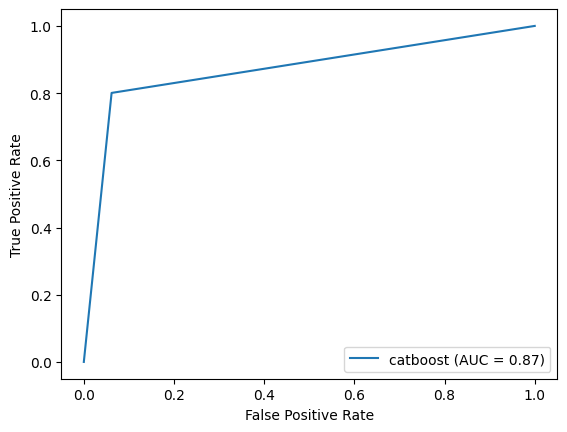

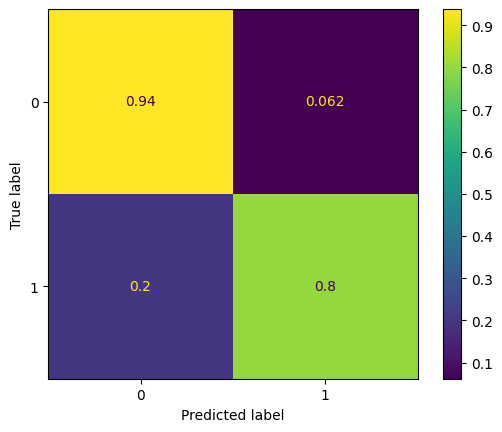

------------


In [11]:
kfold = TimeSeriesSplit(n_splits=5)
pd.options.mode.chained_assignment = None

for i, (train_index, test_index) in enumerate(kfold.split(train_X, train_y)):
    print(train_index)
    print(test_index)

    tr_X, tr_y = train_X.iloc[train_index], train_y.iloc[train_index]
    tst_X, tst_y = train_X.iloc[test_index], train_y.iloc[test_index]

    # Preprocessing
    # cat features
    imp_cat = SimpleImputer(strategy="most_frequent")
    tr_X[cat_cols] = imp_cat.fit_transform(tr_X[cat_cols])
    tst_X[cat_cols] = imp_cat.transform(tst_X[cat_cols])

    # num features
    imp_num = SimpleImputer(strategy='median')
    tr_X[num_cols] = imp_num.fit_transform(tr_X[num_cols])
    tst_X[num_cols] = imp_num.transform(tst_X[num_cols])

    # to str
    tr_X[cat_cols] = tr_X[cat_cols].astype(str)
    tst_X[cat_cols] = tst_X[cat_cols].astype(str)

    # Fit
    train_data = Pool(tr_X, label=tr_y, cat_features=cat_cols)
    test_data = Pool(tst_X, label=tst_y, cat_features=cat_cols)

    model = CatBoostClassifier(
        # iterations=10,
        learning_rate=0.03,
        custom_metric=['Logloss', 'AUC:hints=skip_train~false']
        )

    model.fit(
        train_data,
        verbose=False,
        )
    y_pred = model.predict(test_data)

    # Metrics
    precision, recall, f1_score, _ = precision_recall_fscore_support(tst_y, y_pred, average='weighted')
    roc_auc_val = roc_auc_score(tst_y, y_pred, average='weighted')
    fpr, tpr, thresholds = roc_curve(tst_y, y_pred)
    roc_auc = auc(fpr, tpr)
    cm = confusion_matrix(tst_y, y_pred, normalize='true')

    print(f"Fold {i}:")
    print(f"precision: {precision}")
    print(f"recall: {recall}")
    print(f"f1_score: {f1_score}")
    print(f"ROC AUC: {roc_auc_val}")

    display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='catboost')
    display.plot()
    plt.show()

    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.show()

    print('------------')

# Submission

In [12]:
test_df = test_df.sort_values(by='S_2').reset_index(drop=True)
test_df['day'] = test_df['S_2'].dt.day
test_df['month'] = test_df['S_2'].dt.month
test_df['year'] = test_df['S_2'].dt.year
test_df

,customer_ID,S_2,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,D_42,D_43,D_44,B_4,D_45,B_5,R_2,D_46,D_47,D_48,D_49,B_6,B_7,B_8,D_50,D_51,B_9,R_3,D_52,P_3,B_10,D_53,S_5,B_11,S_6,D_54,R_4,S_7,B_12,S_8,D_55,D_56,B_13,R_5,D_58,S_9,B_14,D_59,D_60,D_61,B_15,S_11,D_62,D_63,D_64,D_65,B_16,B_17,B_18,B_19,D_66,B_20,D_68,S_12,R_6,S_13,B_21,D_69,B_22,D_70,D_71,D_72,S_15,B_23,D_73,P_4,D_74,D_75,D_76,B_24,R_7,D_77,B_25,B_26,D_78,D_79,R_8,R_9,S_16,D_80,R_10,R_11,B_27,D_81,D_82,S_17,R_12,B_28,R_13,D_83,R_14,R_15,D_84,R_16,B_29,B_30,S_18,D_86,D_87,R_17,R_18,D_88,B_31,S_19,R_19,B_32,S_20,R_20,R_21,B_33,D_89,R_22,R_23,D_91,D_92,D_93,D_94,R_24,R_25,D_96,S_22,S_23,S_24,S_25,S_26,D_102,D_103,D_104,D_105,D_106,D_107,B_36,B_37,R_26,R_27,B_38,D_108,D_109,D_110,D_111,B_39,D_112,B_40,S_27,D_113,D_114,D_115,D_116,D_117,D_118,D_119,D_120,D_121,D_122,D_123,D_124,D_125,D_126,D_127,D_128,D_129,B_41,B_42,D_130,D_131,D_132,D_133,R_28,D_134,D_135,D_136,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145,day,month,year
0,cdedd219d06e29cd222ee164c1146d973f100f99e2e9e1...,2018-03-26,0.766602,0.002094,0.019348,1.000977,0.002953,0.103943,0.005711,0.000938,NaN,0.144653,0.000082,0.018387,0.109314,0.142578,0.008522,NaN,0.116028,-0.008331,NaN,1.094727,0.018387,1.002930,0.202759,0.673828,0.086121,0.208252,0.292725,0.618652,5.785156,NaN,0.011673,0.014000,0.008553,1.004883,0.009949,0.088623,0.278320,0.752441,0.009926,NaN,0.209961,0.001080,0.001619,0.003830,0.082703,0.333984,1.001953,-0.001760,0.009956,0.889648,NaN,CO,O,0.005997,0.005596,NaN,1.002930,0.004028,NaN,0.008018,1.0,0.352295,0.005302,1.002930,0.008789,0.003986,0.008873,0.005753,0.042664,0.005459,0.208130,0.010956,NaN,0.008003,0.007889,0.008499,NaN,0.005043,0.009995,NaN,0.138428,0.005974,0.007229,0.003742,0.001868,NaN,0.007164,0.000411,0.009010,0.003307,0.006680,0.008347,NaN,0.006321,1.004883,0.038574,0.001746,0.000512,0.002848,0.006275,0.003494,0.006355,NaN,0.0,0.007542,0.005066,NaN,0.000804,0.004025,NaN,1.0,0.003059,0.005886,0.002237,0.008827,0.002050,0.001565,1.007812,0.002661,0.007492,0.000834,0.508301,1.007812,0.004635,0.001465,0.009338,0.005451,1.003906,0.933105,0.134399,0.943848,0.972656,0.013458,0.002398,0.002104,0.005173,NaN,NaN,0.009117,0.004704,0.019867,NaN,1.006836,2.0,NaN,0.005314,NaN,NaN,NaN,1.003906,0.009583,0.312744,0.601562,1.0,0.024857,0.0,5.0,0.027847,0.023743,0.0,0.140015,0.292969,0.006409,0.188599,1.004883,0.0,0.002361,1.003906,1.007812,0.004242,NaN,0.002541,0.003414,NaN,0.000415,0.005276,NaN,NaN,NaN,NaN,NaN,0.008751,0.009720,0.000743,NaN,0.005665,0.004711,0.001482,26,3,2018
1,37670193a2e6b7de577efed7d78964990dc26981491efc...,2018-03-26,0.994141,0.176514,0.089722,1.000977,0.004631,0.142578,0.007664,0.003473,NaN,NaN,0.009453,0.059479,0.052612,0.090820,0.003050,0.436523,0.829102,0.022827,NaN,0.212524,0.032349,1.008789,NaN,0.001759,0.054596,0.007175,0.207031,0.661133,0.300537,NaN,0.007599,0.066956,0.001634,1.004883,0.002235,0.093445,0.011345,0.324463,0.045990,NaN,0.037842,0.002712,0.000973,0.068481,0.031891,0.482178,0.239258,0.028473,0.004253,0.085938,0.370605,CO,R,0.000858,0.001093,NaN,1.001953,0.005302,NaN,0.008125,6.0,-0.264893,0.007126,0.002867,0.001011,0.004280,0.001156,0.006451,0.009720,0.006020,0.200195,0.025284,NaN,0.003660,0.005562,0.000978,NaN,0.000491,0.003660,0.349854,0.056366,0.001375,0.000954,0.005798,0.005325,NaN,0.005741,0.003664,0.008072,0.006462,0.003571,0.000474,NaN,0.009880,1.006836,0.055054,0.003551,0.009003,0.001829,0.001183,0.008102,0.003368,NaN,0.0,0.005947,0.009384,NaN,0.005016,0.004730,NaN,1.0,0.003971,0.004559,0.007996,0.001949,0.009995,0.004158,1.004883,0.007843,0.004398,0.005314,0.000979,0.007591,0.002550,0.000375,0.009171,0.009811,0.002861,0.934570,0.138062,0.949707,0.978516,0.002298,0.008919,0.007771,0.004433,NaN,NaN,0.009697,0.006580,0.096863,NaN,1.009766,2.0,NaN,0.006340,NaN,NaN,NaN,1.001953,0.024353,0.542480,0.007545,1.0,0.739746,0.0,3.0,0.724609,0.604004,0.0,0.772461,0.286621,0.009102,0.414551,0.001288,1.0,0.008636,1.001953,0.007973,0.007679,0.317383,0.004967,0.006374,NaN,

In [13]:
# Preprocessing
# cat features
test_df[cat_cols] = imp_cat.transform(test_df[cat_cols])
test_df[cat_cols] = test_df[cat_cols].astype(str)

# num features
test_df[num_cols] = imp_num.transform(test_df[num_cols])

In [14]:
# Predict
test_df['target'] = model.predict(test_df[feature_cols])
test_df

,customer_ID,S_2,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,D_42,D_43,D_44,B_4,D_45,B_5,R_2,D_46,D_47,D_48,D_49,B_6,B_7,B_8,D_50,D_51,B_9,R_3,D_52,P_3,B_10,D_53,S_5,B_11,S_6,D_54,R_4,S_7,B_12,S_8,D_55,D_56,B_13,R_5,D_58,S_9,B_14,D_59,D_60,D_61,B_15,S_11,D_62,D_63,D_64,D_65,B_16,B_17,B_18,B_19,D_66,B_20,D_68,S_12,R_6,S_13,B_21,D_69,B_22,D_70,D_71,D_72,S_15,B_23,D_73,P_4,D_74,D_75,D_76,B_24,R_7,D_77,B_25,B_26,D_78,D_79,R_8,R_9,S_16,D_80,R_10,R_11,B_27,D_81,D_82,S_17,R_12,B_28,R_13,D_83,R_14,R_15,D_84,R_16,B_29,B_30,S_18,D_86,D_87,R_17,R_18,D_88,B_31,S_19,R_19,B_32,S_20,R_20,R_21,B_33,D_89,R_22,R_23,D_91,D_92,D_93,D_94,R_24,R_25,D_96,S_22,S_23,S_24,S_25,S_26,D_102,D_103,D_104,D_105,D_106,D_107,B_36,B_37,R_26,R_27,B_38,D_108,D_109,D_110,D_111,B_39,D_112,B_40,S_27,D_113,D_114,D_115,D_116,D_117,D_118,D_119,D_120,D_121,D_122,D_123,D_124,D_125,D_126,D_127,D_128,D_129,B_41,B_42,D_130,D_131,D_132,D_133,R_28,D_134,D_135,D_136,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145,day,month,year,target
0,cdedd219d06e29cd222ee164c1146d973f100f99e2e9e1...,2018-03-26,0.766602,0.002094,0.019348,1.000977,0.002953,0.103943,0.005711,0.000938,0.110657,0.144653,0.000082,0.018387,0.109314,0.142578,0.008522,0.461670,0.116028,-0.008331,0.129150,1.094727,0.018387,1.002930,0.202759,0.673828,0.086121,0.208252,0.292725,0.618652,5.785156,0.018219,0.011673,0.014000,0.008553,1.004883,0.009949,0.088623,0.278320,0.752441,0.009926,0.152710,0.209961,0.001080,0.001619,0.003830,0.082703,0.333984,1.001953,-0.001760,0.009956,0.889648,0.088806,CO,O,0.005997,0.005596,0.896484,1.002930,0.004028,NaN,0.008018,1.0,0.352295,0.005302,1.002930,0.008789,0.003986,0.008873,0.005753,0.042664,0.005459,0.208130,0.010956,0.110657,0.008003,0.007889,0.008499,0.06012,0.005043,0.009995,0.207031,0.138428,0.005974,0.007229,0.003742,0.001868,0.17334,0.007164,0.000411,0.009010,0.003307,0.006680,0.008347,0.504395,0.006321,1.004883,0.038574,0.001746,0.000512,0.002848,0.006275,0.003494,0.006355,0.005157,0.0,0.007542,0.005066,1.0,0.000804,0.004025,0.115021,1.0,0.003059,0.005886,0.002237,0.008827,0.002050,0.001565,1.007812,0.002661,0.007492,0.000834,0.508301,1.007812,0.004635,0.001465,0.009338,0.005451,1.003906,0.933105,0.134399,0.943848,0.972656,0.013458,0.002398,0.002104,0.005173,0.337891,0.136475,0.009117,0.004704,0.019867,0.037048,1.006836,2.0,0.005346,0.005314,0.91333,1.003906,0.232178,1.003906,0.009583,0.312744,0.601562,1.0,0.024857,0.0,5.0,0.027847,0.023743,0.0,0.140015,0.292969,0.006409,0.188599,1.004883,0.0,0.002361,1.003906,1.007812,0.004242,0.020645,0.002541,0.003414,0.156372,0.000415,0.005276,0.22583,0.005093,0.25415,0.005024,0.007011,0.008751,0.009720,0.000743,0.384521,0.005665,0.004711,0.001482,26,3,2018,0
1,37670193a2e6b7de577efed7d78964990dc26981491efc...,2018-03-26,0.994141,0.176514,0.089722,1.000977,0.004631,0.142578,0.007664,0.003473,0.110657,0.092651,0.009453,0.059479,0.052612,0.090820,0.003050,0.436523,0.829102,0.022827,0.129150,0.212524,0.032349,1.008789,0.110291,0.001759,0.054596,0.007175,0.207031,0.661133,0.300537,0.018219,0.007599,0.066956,0.001634,1.004883,0.002235,0.093445,0.011345,0.324463,0.045990,0.152710,0.037842,0.002712,0.000973,0.068481,0.031891,0.482178,0.239258,0.028473,0.004253,0.085938,0.370605,CO,R,0.000858,0.001093,0.896484,1.001953,0.005302,NaN,0.008125,6.0,-0.264893,0.007126,0.002867,0.001011,0.004280,0.001156,0.006451,0.009720,0.006020,0.200195,0.025284,0.110657,0.003660,0.005562,0.000978,0.06012,0.000491,0.003660,0.349854,0.056366,0.001375,0.000954,0.005798,0.005325,0.17334,0.005741,0.003664,0.008072,0.006462,0.003571,0.000474,0.504395,0.009880,1.006836,0.055054,0.003551,0.009003,0.001829,0.001183,0.008102,0.003368,0.005157,0.0,0.005947,0.009384,1.0,0.005016,0.004730,0.115021,1.0,0.003971,0.004559,0.007996,0.001949,0.009995,0.004158,1.004883,0.007843,0.004398,0.005314,0.000979,0.007591,0.002550,0.000375,0.009171,0.009811,0.002861,0.934570,0.138062,0.949707,0.978516,0.002298,0.008919,0.007771,0.004433,0.337891,0.136475,0.009697,0.006580,0.096863,0.037048,1.0097

In [15]:
from pathlib import Path

save_dir = './data'
Path(save_dir).mkdir(parents=True, exist_ok=True)
test_df.to_excel(f"{save_dir}/submission.xlsx", index=False)